## Recreating Experiment 1, Levin et al., 2018 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.linalg import orthogonal_procrustes
from sklearn.utils.validation import check_is_fitted
from tqdm.notebook import tqdm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from graspy.simulations import rdpg
from graspy.embed.base import BaseEmbed
from graspy.plot import heatmap, pairplot
from graspy.utils import (
    import_graph,
    is_fully_connected,
    augment_diagonal,
    pass_to_ranks,
    is_unweighted,
)

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 120

In [ ]:
class AdjacencySpectralEmbed(BaseEmbed):
    r"""
    bla bla bla
    """

    def __init__(
        self,
        n_components=None,
        n_elbows=2,
        algorithm="randomized",
        n_iter=5,
        check_lcc=True,
        diag_aug=True,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            algorithm=algorithm,
            n_iter=n_iter,
            check_lcc=check_lcc,
        )

        if not isinstance(diag_aug, bool):
            raise TypeError("`diag_aug` must be of type bool")
        self.diag_aug = diag_aug

    def fit(self, graph, y=None):
        # would add the pseudoinverse
        # as a class attribute in fit
        """
        bla bla bla
        """
        A = import_graph(graph)

        if self.check_lcc:
            if not is_fully_connected(A):
                msg = (
                    "Input graph is not fully connected. Results may not"
                    + "be optimal. You can compute the largest connected component by"
                    + "using ``graspy.utils.get_lcc``."
                )
                warnings.warn(msg, UserWarning)

        if self.diag_aug:
            A = augment_diagonal(A)

        self._reduce_dim(A)
        self.is_fitted_ = True
        return self
    
    def predict(self, y):
        check_is_fitted(self, 'is_fitted_')
        self.pinv_ = self.latent_left_ @ (np.diag(1/self.singular_values_))
        return y @ self.pinv_

![Figure 1](../figs/figure1_original.png)

Empirical distribution of the LLS OOS estimate for 100 independent trials for number of vertices n = 50 (left), n = 100 (middle) and n = 500 (right). Each plot shows the positions of 100 independent OOS embeddings, indicated by crosses, and colored according to cluster membership. Contours indicate two generalized standard deviations of the multi- variate normal (i.e., 68% and 95% of the probability mass) about the true latent positions, which are indicated by solid circles. We note that even with merely 100 vertices, the normal approximation is already quite reasonable.

In [3]:
def confidence_ellipse(data, ax, mean=None, n_std=3.0, facecolor='none', **kwargs):
    """
    make confidence ellipse for plot
    """
    x, y = data[:, 0], data[:, 1]
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    if mean is None:
        mean_x = np.mean(x)
    else:
        mean_x = mean[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    if mean is None:
        mean_y = np.mean(y)
    else:
        mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def trial(n):
    # known parameters
    labels = ["blue"]*n + ["red"]*n
    lamb = np.array([0.4, 1-.4])
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])
    latents = np.vstack((x1, x2))
    
    # generate latent positions
    latents = np.repeat(latents, n, axis=0)

    # generate M from rdpg
    M = rdpg(latents)

    # index out oos
    p = np.repeat(lamb, n) / n
    i = np.random.choice(n*2, p=p)
    label = labels[i]
    a = M[i, :]
    a = np.delete(a, i)
    A = np.delete(M, i, 0)
    A = np.delete(A, i, 1)
    latents_ = np.delete(latents, i, 0)

    # embed without oos stuff
    ase = AdjacencySpectralEmbed(n_components=2)
    ase.fit(A)

    # Procrustes alignment
    R, _ = orthogonal_procrustes(ase.latent_left_, latents_)

    # predict oos
    w = ase.predict(a)
    w = w @ R

    return w, label

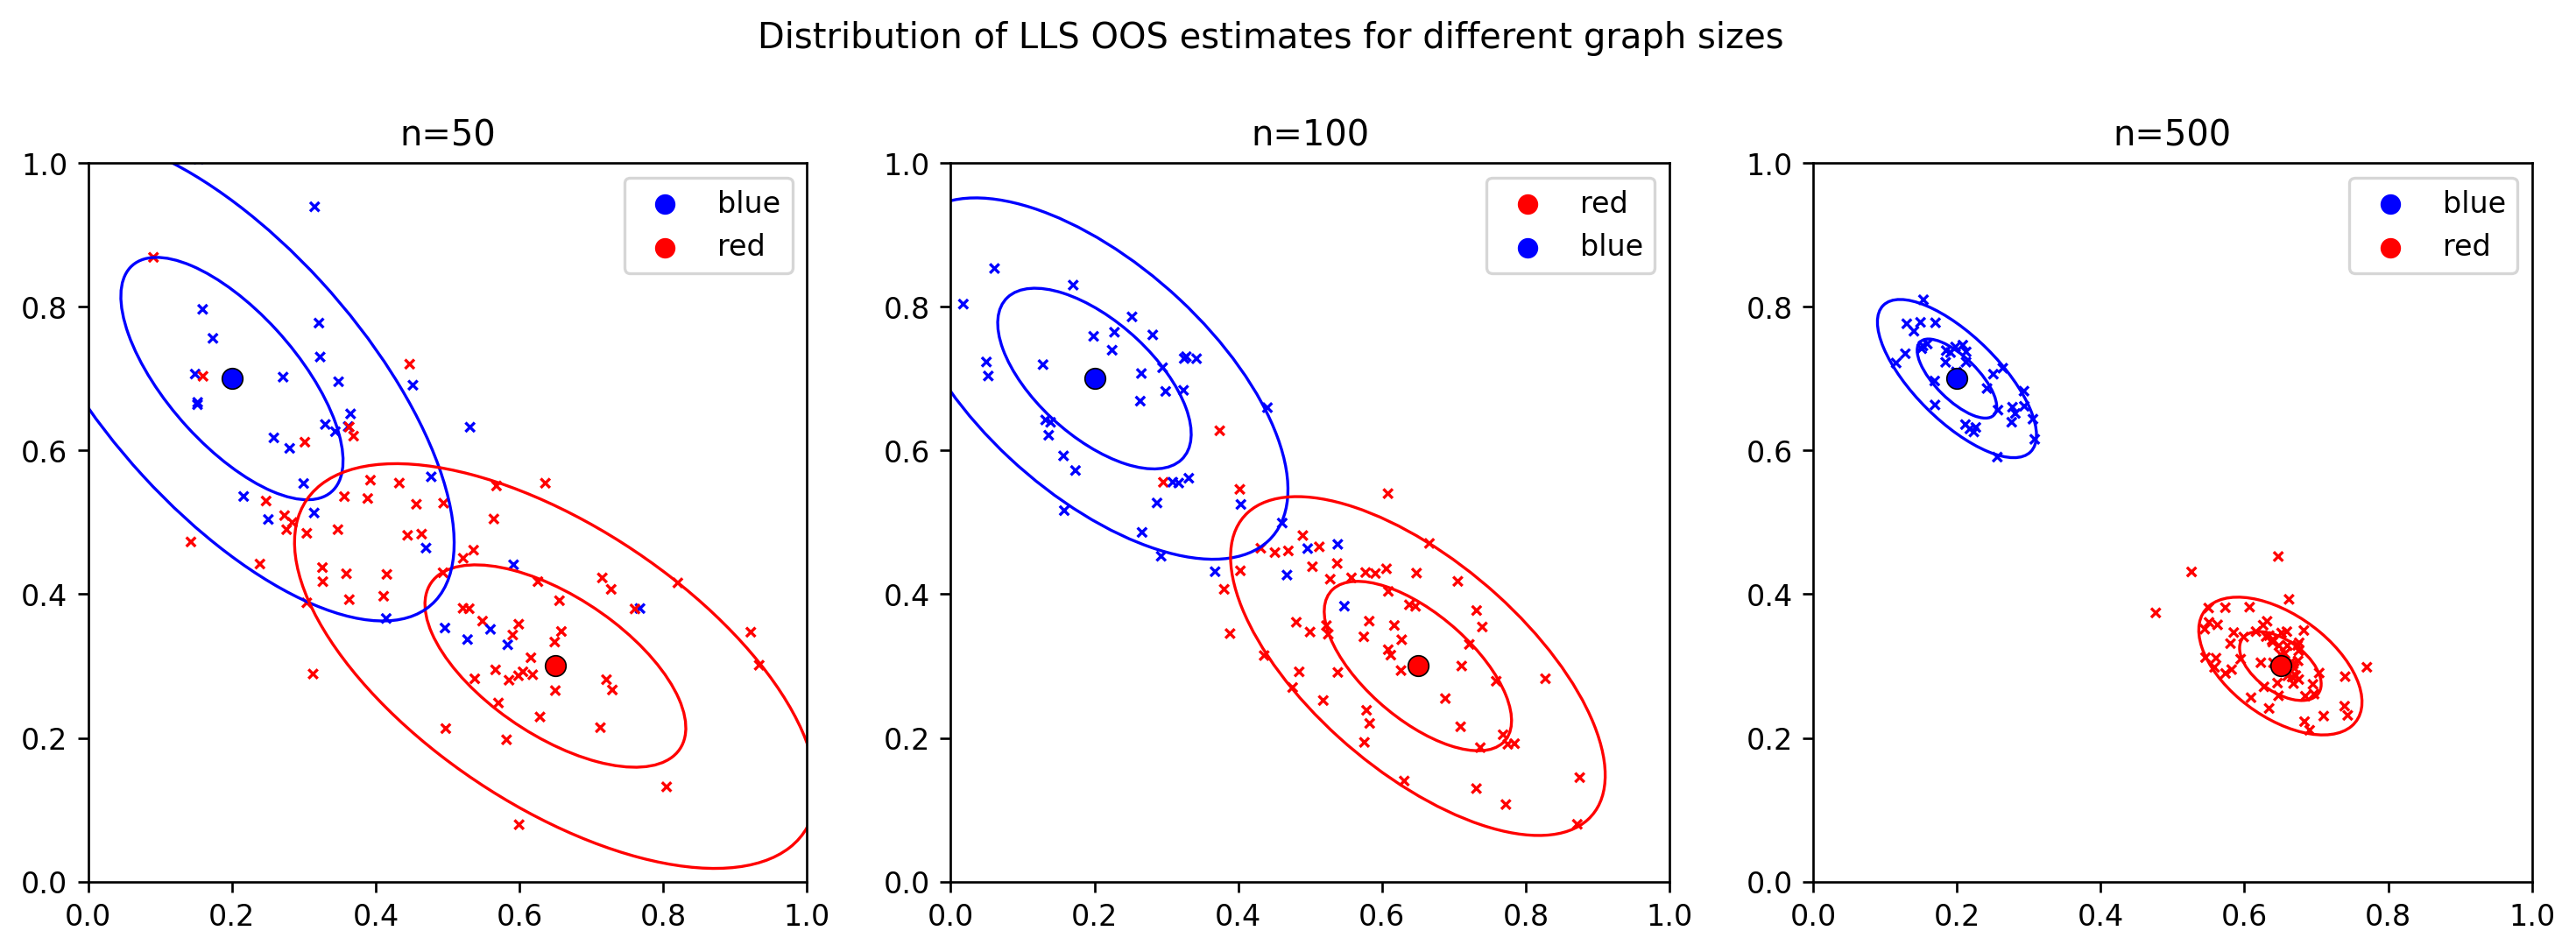

In [4]:
# run 100 trials and plot
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, n_ in enumerate([50, 100, 500]):
    n = n_ // 2
    ws = []
    labels = []
    for _ in tqdm(range(100)):
        w, label = trial(n)
        ws.append(list(w))
        labels.append(label)

    ws = np.array(ws)
    labels = np.array(labels)
    x, y = ws[:, 0], ws[:, 1]

    # separate labels and set parameters
    blues = ws[labels == 'blue']
    reds = ws[labels == 'red']
    x1 = np.array([.2, .7])
    x2 = np.array([.65, .3])

    # plot
    sns.scatterplot(x, y, ax=axes[i], hue=labels, palette={'red': 'r', 'blue': 'b'}, marker='x', linewidth=1, s=10)
    axes[i].scatter(x1[0], x1[1], marker='o', c='b', s=50, edgecolors='k', linewidth=.5)  # didn't work
    axes[i].scatter(x2[0], x2[1], marker='o', c='r', s=50, edgecolors='k', linewidth=.5)
    for std in range(1, 3):
        confidence_ellipse(blues, ax=axes[i], mean=x1, n_std=std, edgecolor='b')
        confidence_ellipse(reds, ax=axes[i], mean=x2, n_std=std, edgecolor='r')
    
    # make sure aspects are correct
    axes[i].set_aspect('equal')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, 1)
    
    # title
    axes[i].set_title(f'n={n_}')
    
fig.suptitle("Distribution of LLS OOS estimates for different graph sizes");
plt.savefig("../figs/oos_estimates_distribution.png", dpi=600)